## UMAP embedding of different representations

Choices include:

- SynapseCLR backbone
- SynapseCLR projection middle
- SynapseCLR projection head
- Random
- MedicalNet

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from IPython.display import HTML
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation 
import numpy as np

import colorcet as cc
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from synapse_utils import io

import cuml
from cuml import PCA, TSNE, UMAP

from synapse_utils.commons import load_imputed_annotations, log1p_zscore

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Choose representation

In [2]:
repo_root = '../..'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

run_prefix = 'medicalnet'
checkpoint_path = '../../output/checkpoint__medicalnet'
reload_epoch = 0
node_idx_list = [0]
load_prefix = 'encoder.fc'

# run_prefix = 'random'
# checkpoint_path = '../../output/checkpoint__random'
# reload_epoch = 0
# node_idx_list = [0]
# load_prefix = 'encoder.fc'

# run_prefix = 'synapseclr_backbone'
# checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
# reload_epoch = 99
# node_idx_list = [0, 1, 2, 3]
# load_prefix = 'encoder.fc'

# run_prefix = 'synapseclr_projection_middle'
# checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
# reload_epoch = 99
# node_idx_list = [0, 1, 2, 3]
# load_prefix = 'projector.mlp.0'

# run_prefix = 'synapseclr_projection_head'
# checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
# reload_epoch = 99
# node_idx_list = [0, 1, 2, 3]
# load_prefix = 'projector.mlp.3'

# these are pre-computed (can be set to None)
contamination_indices_path = os.path.join(
    checkpoint_path, 'indices', 'contamination_meta_df_row_indices.npy')

In [3]:
imputed_cell_types_df_path = '../../output/consensus/consensus__meta__uncensored.csv'
imputed_meta_ext_df_path = '../../output/gp/synapse_simclr_production/imputed_meta__rbf__synapse_simclr__ensemble.csv'

## 2D Embedding

In [4]:
# load features
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

n_pca_components = 128
if n_pca_components < features_nf.shape[-1]:
    features_nf = PCA(n_components=n_pca_components).fit_transform(features_nf)

In [5]:
# (optionally) load
import pickle

embedding_type = 'UMAP'

try:
    features_n2 = np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'))
    with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'rb') as f:
        loader = pickle.Unpickler(f)
        umap_2d_fit = loader.load()
    embedding_2d_loaded = True
    
except:
    embedding_2d_loaded = False

In [6]:
if not embedding_2d_loaded:
    
    embedding_type = 'UMAP'
    save_results = True

    # for UMAP
    n_neighbors = 500
    n_epochs = 5000
    learning_rate = 1.0
    spread = 1.0
    min_dist = 0.1

    # for t-SNE
    perplexity = 10


    if embedding_type == 'UMAP':

        umap_2d_fit = UMAP(
            min_dist=min_dist,
            spread=spread,
            n_neighbors=n_neighbors,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            random_state=42).fit(features_nf)

        features_n2 = umap_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'wb') as f:
                pickle.dump(umap_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'),
                features_n2)

    elif embedding_type == 'TSNE':

        tsne_2d_fit = TSNE(
            perplexity=perplexity,
            n_neighbors=n_neighbors,
            learning_rate_method=None).fit(features_nf)

        features_n2 = tsne_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d__fit.pkl'), 'wb') as f:
                pickle.dump(tsne_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d.npy'),
                features_n2)

## Overlay anotations

In [7]:
# which annotations to use?
annotations_to_use = 'manual'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()
    analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
    analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)
    output_subdir = 'manual/'

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)
    output_subdir = ''

In [8]:
# helper function
def get_row_indices_from_synapse_ids(synapse_ids):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

In [9]:
analysis_synapse_ids = analysis_meta_ext_df['synapse_id'].values
analysis_indices = get_row_indices_from_synapse_ids(analysis_synapse_ids)

In [10]:
panel_size = (4, 4)
alpha = 1.0
s = 2.

## Unannotated

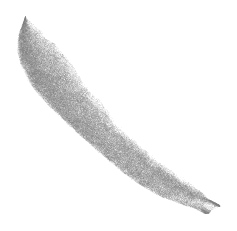

In [11]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=1.,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__unannotated.pdf', dpi=400, bbox_inches='tight')

### Cleft size

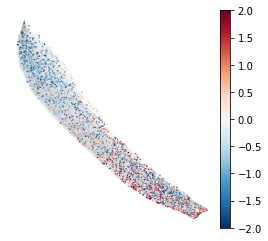

In [12]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['cleft_size_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__cleft_size.pdf', dpi=300, bbox_inches='tight')

### Pre-synaptic process size

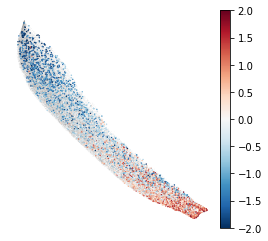

In [13]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__pre_vol.pdf', dpi=300, bbox_inches='tight')

### Post-synaptic process size

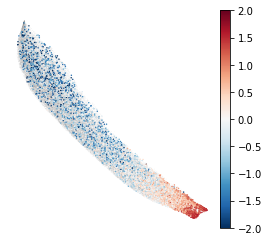

In [14]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__post_vol.pdf', dpi=300, bbox_inches='tight')

### Pre-synaptic soma distance

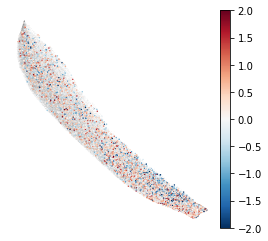

In [15]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['presyn_soma_dist_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__pre_soma_dist.pdf', dpi=300, bbox_inches='tight')

### Post-synaptic soma distance

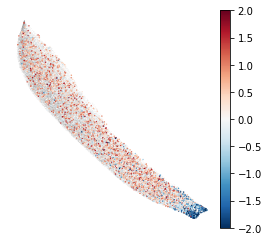

In [16]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['postsyn_soma_dist_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__post_soma_dist.pdf', dpi=300, bbox_inches='tight')

### Pre-synaptic MT volume

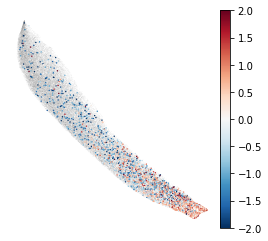

In [17]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_pre'].values.astype(bool)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0][mask],
    features_n2[analysis_indices, 1][mask],
    c=analysis_meta_ext_df['mito_size_pre_vx_log1p_zscore_zi'].values[mask],
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__pre_mito_vol.pdf', dpi=300, bbox_inches='tight')

### Post-synaptic MT volume

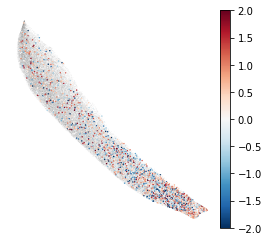

In [18]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_post'].values.astype(bool)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0][mask],
    features_n2[analysis_indices, 1][mask],
    c=analysis_meta_ext_df['mito_size_post_vx_log1p_zscore_zi'].values[mask],
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__post_mito_vol.pdf', dpi=300, bbox_inches='tight')

### Has Pre-synaptic MT?

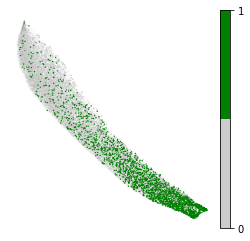

In [19]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_pre'].values.astype(bool)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'green'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask.astype(float),
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__has_pre_mito.pdf', dpi=300, bbox_inches='tight')

### Has Post-synaptic MT?

In [ ]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_post'].values.astype(bool)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'green'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask.astype(float),
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__has_post_mito.pdf', dpi=300, bbox_inches='tight')

## Ex to Ex

In [ ]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 0) & (analysis_meta_ext_df['post_cell_type'].values == 0)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__cell_type__ex_to_ex.pdf', dpi=300, bbox_inches='tight')

## Ex to In

In [ ]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 0) & (analysis_meta_ext_df['post_cell_type'].values == 1)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__cell_type__ex_to_in.pdf', dpi=300, bbox_inches='tight')

## In to Ex

In [ ]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 1) & (analysis_meta_ext_df['post_cell_type'].values == 0)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__cell_type__in_to_ex.pdf', dpi=300, bbox_inches='tight')

## In to In

In [ ]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 1) & (analysis_meta_ext_df['post_cell_type'].values == 1)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.1,
    vmin=-2,
    vmax=2,
    alpha=0.3,
    color='gray',
    marker='o',
    facecolor='gray',
    edgecolor='none',
    rasterized=True)

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap,
    marker='o',
    edgecolor='none')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(f'../../output/analysis/umap_different_features/{output_subdir}umap__{run_prefix}__{save_prefix}__cell_type__in_to_in.pdf', dpi=300, bbox_inches='tight')